In [1]:
# Impoting required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.lines as mlines

# setting default option
pd.set_option("mode.copy_on_write", True)
warnings.simplefilter(action="ignore", category=FutureWarning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# loading the Datasets
mortality = pd.read_parquet("/Users/robintitus/Desktop/PDS/Dec 12/Opioid-Team-Project-Group-9/Data/processed/mortality_corrected.parquet")
shipment = pd.read_parquet("/Users/robintitus/Desktop/PDS/Dec 12/Opioid-Team-Project-Group-9/Data/processed/shipment_corrected.parquet")

In [3]:
shipment.sample(5)

,BUYER_STATE,BUYER_COUNTY,YEAR,MME,countyfips,Population
18775,MO,BARTON,2006,3.482195e+06,29011,12972
19158,MO,DENT,2011,8.964969e+06,29065,15620
40859,WI,FOREST,2015,1.765609e+06,55041,9015
13941,KY,LAWRENCE,2006,1.777104e+07,21127,15766
35574,TX,GALVESTON,2011,8.086590e+07,48167,295632


In [4]:
#Control vars state setup
test_state = 'FL'
control_states = ['GA', 'NC', 'LA']

#Control vars year setup
policy_year = 2010
start_year = 2007
end_year = 2013

In [5]:
# Subset datasets
def prepare_data(dataset, test_state, control_states, policy_year, start_year, end_year):
    # Filter states
    state_list = [test_state] + control_states
    dataset = dataset[dataset["BUYER_STATE"].isin(state_list)]

    # Filter years
    dataset = dataset[(dataset["YEAR"] >= start_year) & (dataset["YEAR"] <= end_year)]

    # Tagging for pre-post policy implementation and test-control
    dataset["policy_implementation"] = dataset["YEAR"] >= policy_year
    dataset["State_Type"] = dataset["BUYER_STATE"].apply(lambda x: "Test" if x == test_state else "Control")

    return dataset


In [6]:
shipment = prepare_data(shipment, test_state, control_states, policy_year, start_year, end_year)
shipment.sample(5)

,BUYER_STATE,BUYER_COUNTY,YEAR,MME,countyfips,Population,policy_implementation,State_Type
6114,GA,LUMPKIN,2011,7.651508e+06,13187,30453,True,Control
5890,GA,IRWIN,2011,1.565820e+06,13155,9677,True,Control
15307,LA,SAINT BERNARD,2010,1.936408e+07,22087,36821,True,Control
15025,LA,IBERVILLE,2008,1.684468e+07,22047,33685,False,Control
4679,FL,PUTNAM,2007,3.964050e+07,12107,75107,False,Test


In [7]:
def plot_pre_post_policy_graph(dataset, test_state, policy_year, metric_column):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Convert YEAR and metric_column to float64
    dataset = dataset.copy()  # Copy to avoid changing the original dataframe
    dataset['YEAR'] = dataset['YEAR'].astype('float64')
    dataset[metric_column] = dataset[metric_column].astype('float64')

    sns.regplot(
        data=dataset[(dataset["BUYER_STATE"] == test_state) & (dataset["policy_implementation"] == True)],
        x="YEAR", y=metric_column, line_kws={"color": "red"}, ax=ax, scatter=False)

    sns.regplot(
        data=dataset[(dataset["BUYER_STATE"] == test_state) & (dataset["policy_implementation"] != True)],
        x="YEAR", y=metric_column, line_kws={"color": "blue"}, ax=ax, scatter=False)

    ax.axvline(policy_year, ls="--", color="orange")

    plt.legend(handles=[mlines.Line2D([], [], color="blue", label="Pre-Policy"),
                        mlines.Line2D([], [], color="red", label="Post-Policy")], loc="lower right")

    plt.title(f"Pre-Post Policy Implementation Shipment Trend for {test_state}")
    plt.ylabel(f"{metric_column} (Units)")

    plt.show()



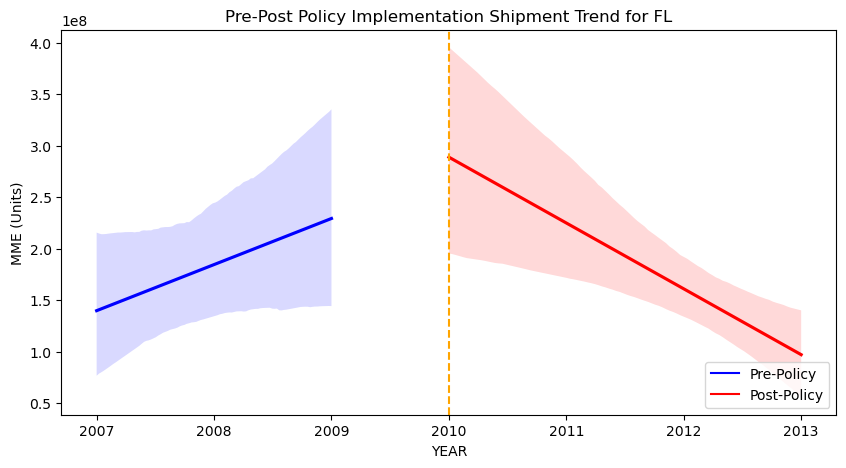

In [8]:
plot_pre_post_policy_graph(shipment, test_state, policy_year, 'MME')

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

def plot_diff_in_diff_graph(dataset, test_state, policy_year, metric_column):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Convert YEAR and metric_column to float64
    dataset = dataset.copy()  # Copy to avoid changing the original dataframe
    dataset['YEAR'] = dataset['YEAR'].astype('float64')
    dataset[metric_column] = dataset[metric_column].astype('float64')

    # Plotting for test state - pre-policy
    sns.regplot(
        data=dataset[(dataset["State_Type"] == "Test") & (dataset["policy_implementation"] != True)],
        x="YEAR", y=metric_column, line_kws={"color": "blue"}, ax=ax, scatter=False)

    # Plotting for test state - post-policy
    sns.regplot(
        data=dataset[(dataset["State_Type"] == "Test") & (dataset["policy_implementation"] == True)],
        x="YEAR", y=metric_column, line_kws={"color": "blue"}, ax=ax, scatter=False)

    # Plotting for control states - pre-policy
    sns.regplot(
        data=dataset[(dataset["State_Type"] == "Control") & (dataset["policy_implementation"] != True)],
        x="YEAR", y=metric_column, line_kws={"color": "red"}, ax=ax, scatter=False)

    # Plotting for control states - post-policy
    sns.regplot(
        data=dataset[(dataset["State_Type"] == "Control") & (dataset["policy_implementation"] == True)],
        x="YEAR", y=metric_column, line_kws={"color": "red"}, ax=ax, scatter=False)

    # Adding vertical line for policy year
    ax.axvline(policy_year, ls="--", color="orange")

    # Creating custom legend handles
    blue_line = mlines.Line2D([], [], color="blue", label="Test State")
    red_line = mlines.Line2D([], [], color="red", label="Control States")

    # Adding legends
    plt.legend(handles=[blue_line, red_line], loc="lower right")
    plt.title(f"Difference-in-Difference Analysis for {test_state}")
    plt.ylabel(f"{metric_column} (Units)")

    plt.show()


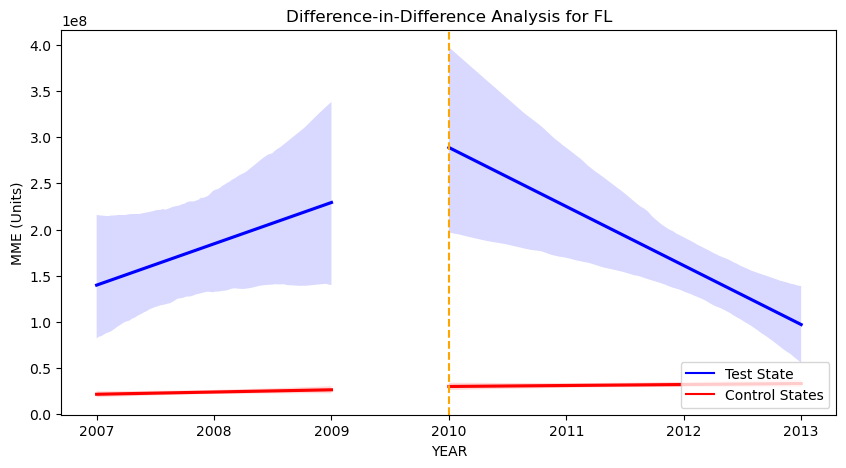

In [10]:
plot_diff_in_diff_graph(shipment, test_state, policy_year, 'MME')